In [19]:
import pyspark 
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import numpy as np
import random

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

In [20]:
# Creating Spark session
spark=SparkSession.builder.appName('HW4').getOrCreate()

# Read data from the pca and save it as Pyspark sql dataframe (done in order to get rdds from the dataframes)
df_pysparkfamc3 = spark.read.option('header','true').json('famc_3.json')

#Create RDD from dataframe 
dfrddfamc3 = df_pysparkfamc3.rdd 

## 2.3 Clustering!


### 2.3.1: Implement K-means using MapReduce

To implement the Kmeans algorithm using MapReduce, we divided the algorithm in two steps (the map ine and the reduce one). 
The first assigns at each point in the dataset a key-values pair where the key is $i$ s.t. $c_i = \argmin_{c_j\in C} ||x - c||_2^2$ where $C$ is the set of the centroids, and the value is a couple itself: (point, 1).
The reduce phase consists in, after having goruped the points by key, summing in a component-wise way all values of the points that have been assigned to each cluster. This way, for each cluster-label $i$ (the *key* of the Map step), we get the couple  $\big( \sum_{x \in C_i} x, \, \# C_i \big)$ where $C_i$ is the $i$-th cluster. This gives us the possibility to compute the new centroids by multipling the vector in the first entrance for $1/ \# C_i$, so dividing each element of the vector by the value we get as second entrance of the reduce phase output. At this point, we check the convergence of the algorithm by checking if the new centroids are the same as the ones before. If that's not the case, we call recursivly the Kmeans function replacing the starting centroids with the new ones and updating the number of iterations.

In [21]:
def extract_starting_centroids(rdd, k):
    #returns k samples extracted from our dataset(in rdd form) without replacement
    return rdd.takeSample(False, k)

def euclidean_squared_distance(x, y): #Computes the square of the euclidean distance between two points 
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    return (np.linalg.norm(x-y))**2

# Function used to check the convergence of the Kmeans algorithm: checks if the centroids of two following iterations are the same 
checkconvergencefun = lambda l1, l2: sum(sum([el1 - el2 for (el1, el2) in zip(l1, l2)]))

In [22]:
def Kmeans(rdd_data, centroids, k, it):
    niter = it
    # MAP PHASE: assign to each point a key-value pair -> key: the label of the cluster it's assigned to; value: (point, 1) 
    rddmap = rdd_data.map(lambda point:(np.argmin([ euclidean_squared_distance(point, centroid) for centroid in centroids ]), (point, 1)))

    # REDUCE PHASE: for each key(cluster) we get (sum_{point in the cluster}, #{points in the clusters})
    rddreduce = rddmap.reduceByKey(lambda t1, t2: (np.add(t1[0], t2[0]), t1[1] + t2[1]) )

    # COMPUTE THE NEW CENTROIDS: new centroid = mean of the points in each cluster = sum_{point in the cluster}/#{points in the clusters} => for each point, 
    new_centroids = rddreduce.mapValues(lambda t: t[0]/t[1]).map(lambda t: t[1])
    new_centr_list = new_centroids.collect()

    # CHECKING CONVERGENCE 
    if checkconvergencefun([np.array(centroid) for centroid in centroids], new_centr_list) == 0:
        # Compute the clusters
        clusters = rddmap.groupByKey().sortByKey().mapValues(lambda iterable: [t[0] for t in list(iterable)]).collect()
        # List of keys corresponding to the cluster each point its assigned to (ordered by appearence of the points in the dataset)
        clusters_idx  = rddmap.map(lambda t: t[0]).collect()
        return clusters, clusters_idx, new_centr_list, niter
    else:
        # Update the number of iterations
        niter += 1
        # Iterative call 
        return Kmeans(rdd_data, new_centr_list, k, niter)


### 2.3.2: Find an optimal number of clusters using at least two different methods.

*Method 1*: Elbow method

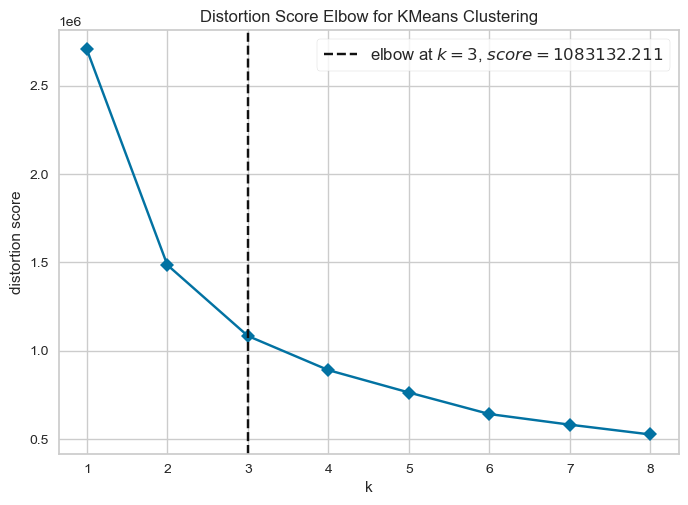

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# Reading data from the PCA
data = pd.read_json('famc_3.json', lines=True)

# Inintialize clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 9),  timings=False, locate_elbow=True) #not showing the time cause it's not relevant since we won't be using the pre-implemented Kmeans algorithm to cluster

# Fit the model 
visualizer.fit(data)  

# Show results
visualizer.show()

**Method 2. Silhouette coefficient**

100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


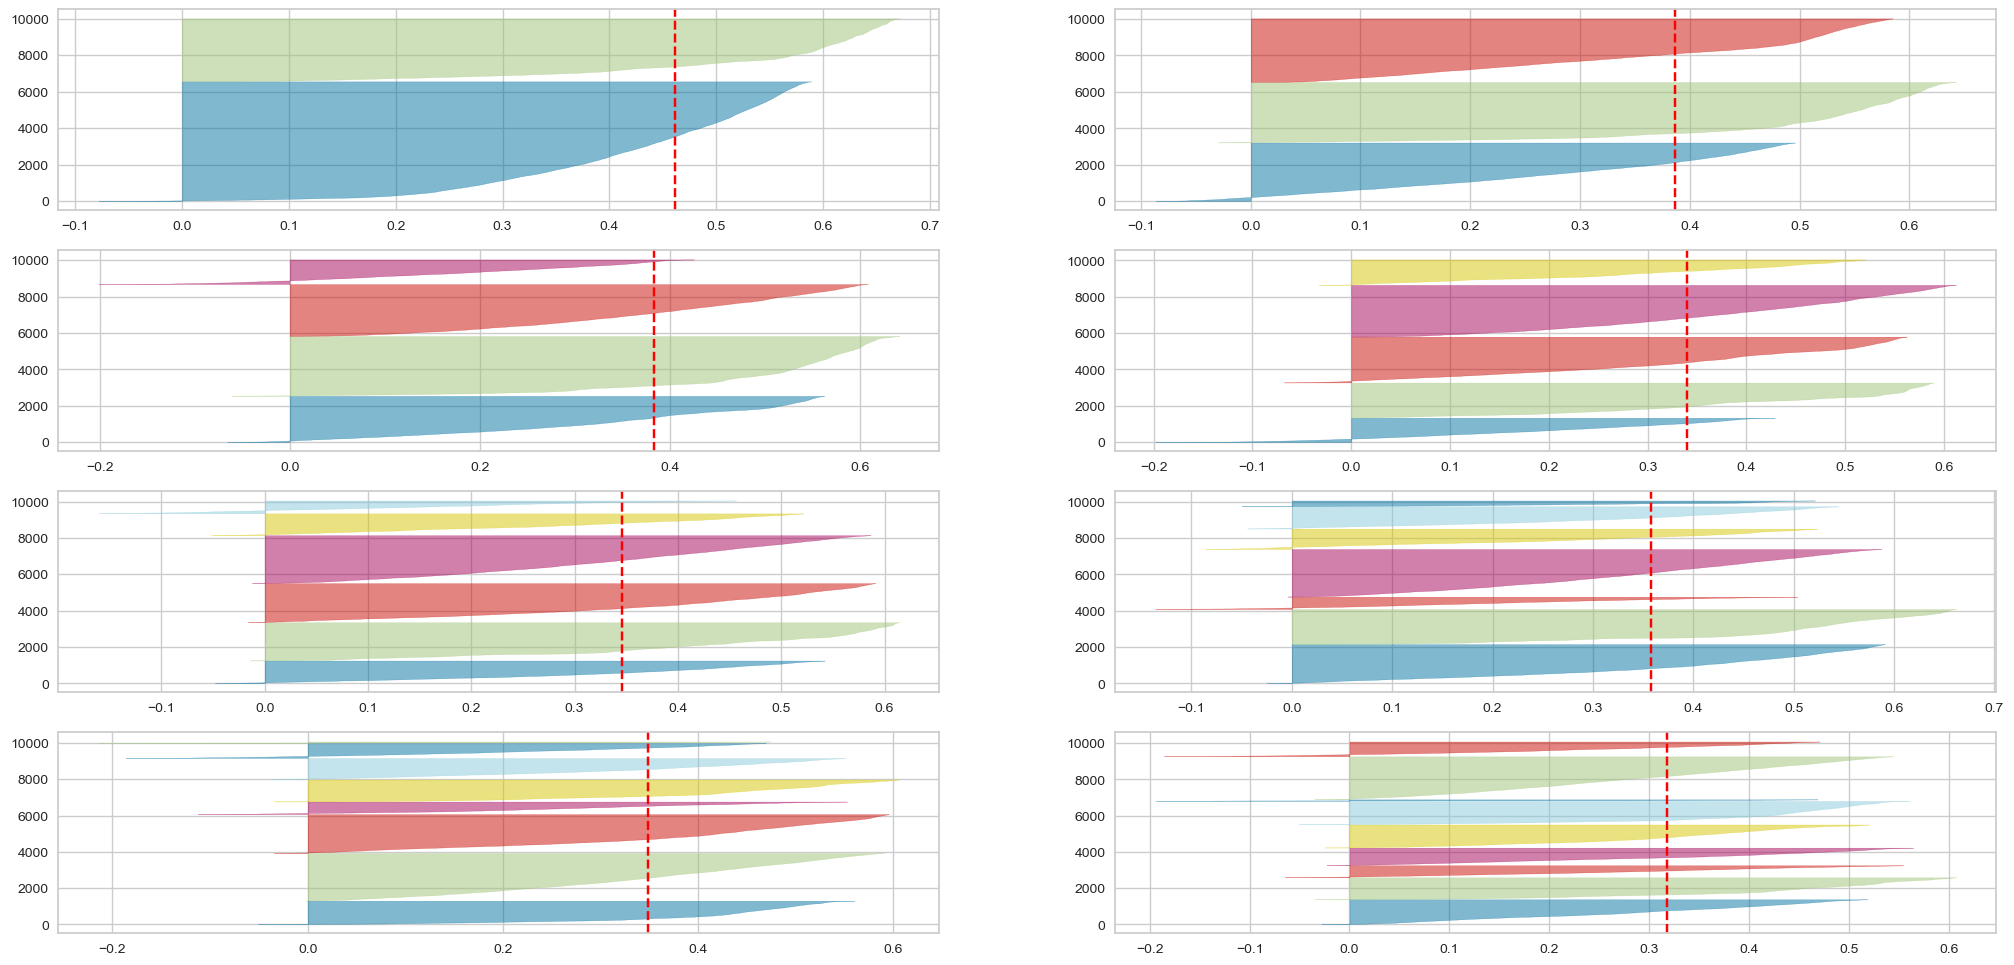

In [6]:
# Reading data from the pca and taking a sample of it to see the Silhouette score due to computational reasons
data= pd.read_json('famc_3.json', lines=True)
sample = data.sample(n = 10000)

# Setting plot structure
fig, ax = plt.subplots(4, 2, figsize=(25, 12))

for i in tqdm(range(2, 10)):
    # Performing clustering using the pre-implemented Kmeans algorithm and fixing the number of clusters to i 
    km = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)

    # Initializing the visualizer for the silhouette score
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    
    # Computing Silhouette score and visualizing the results 
    visualizer.fit(sample)

To choose the appropriate number of clusters we decided to use the Elbow method and the analysis of the Silhouette score.    
For the first method, as can be seen from the plot, we have the the pre-implemented Elbow visualizer detects an elbow at k = 3, but the elbow itself isn't really percievable.
Besides, for the Silhoette score analysis, we can see that the best average score is reached with k=2, but is below 0.5 which make the presence of well distinguished clusters in the data questionable.
Our final choice is to set k=2, following the lead of the Silhouette score, since this method considers not only the intra-cluster variation, but also the between-clusters one.

### 2.3.3: Run the algorithm on the data obtained from the dimensionality reduction.

In [23]:
#results - FAMC 3, Kmeans with k=2
centroids = extract_starting_centroids(dfrddfamc3, 2)
_, keys3, centroids_final,  niter3 = Kmeans(dfrddfamc3, centroids, 2, 0)

#Insert cluster label in the original dataframe
dftotal3 = pd.read_json('allvariables.json', lines=True)
dftotal3.insert(0, 'Cluster', keys3) 

In [24]:
print('The number of iterations made by the Kmeans algorithm is:', niter3)
dftotal3

The number of iterations made by the Kmeans algorithm is: 4


,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,1,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,0,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,0,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,0,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,0,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,1,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,1,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,1,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,0,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


### 2.3.4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

To write the code for the Kmeans++ algorithm, we leverage the fact that the only difference with the Kmeans algorithm it's the computation of the staring centroids: we implmented a new function that computes the starting centroids according the Kmeans ++ algorithm, and use it to compute them, then we call the Kmeans function on these centoids to get the clusters.    
In order to compute the starting centroids we used the pre-implemented function "choices" from the module "random" since it lets us fix the weigths with wich each centroid has to be selected. This serves exactly our purpose since each centroid needs to be calculated accordingly to its minimum distance from the previous ones. 

In [25]:
def get_centroids_Kmeans_pp(data, k):
    n = len(data)
    data = data.values
    
    #initialize the list of centroids indeces by choosing the first one uniformly at random and saving it 
    centroids_indeces = [random.randint(0, n)]
    centroids = [np.array(data[centroids_indeces[-1], :])]

    # compute the remaining k-1 centroids
    for _ in range(1, k):
        #initialize list with squared distances from the nearest centeroids
        distances_nc = []

        for point in data:

            #find the nearest centroid between the ones already computed and save its distance from the point 
            #(we can directly use the squared distance beacause is an increasing function in [0, +\infty) => we "save" computational cost])
            distances = np.array([euclidean_squared_distance(point, centroid) for centroid in centroids]).flatten()#compute sistances between point - centroids
            distances_nc.append(np.min(distances, axis =0)) #save the smallest distance

        #choose the new centroid wrt their distance from the nearest centroid between the ones already computed
        centroids.append(random.choices(data, weights=distances_nc, k=1)[0])
        
    return centroids        
       

def kmeans_plusplus(datardd, datapddf, k):
    # Initialize the centroids for the first iteration
    centroids_pp = get_centroids_Kmeans_pp(datapddf, k)

    # Use the previous clustering (k-Means) algorithm to compute the clusters
    return Kmeans(datardd, centroids_pp, k, 0)

In [26]:
# Reading the data coming from the FAMC in a pandas dataframe, in oder to be ble to compute the initial centroids of kmeans ++)
df_famc3 = pd.read_json('famc_3.json', lines=True)

#results - FAMC 3, Kmeans ++
_, keys_pp3, centroids_pp,  niter_pp3 = kmeans_plusplus(dfrddfamc3, df_famc3, 2)

#Insert cluster label in the original dataframe
dftotal3_pp = pd.read_json('allvariables.json', lines=True)
dftotal3_pp.insert(0, 'Cluster', keys_pp3) 

In [27]:
print('The number of iterations made by the Kmeans++ algorithm is:', niter_pp3)
dftotal3_pp

The number of iterations made by the Kmeans++ algorithm is: 7


,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,1,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,0,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,0,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,0,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,0,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,1,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,1,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,1,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,0,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


In order to compare the results from the two algorithms (Kmeans and Kmeans++), we did a scatterplot of the data and the resulting centroids. From these plots, we can see that the results we get are the same, except for the order of the clusters. Besides, we can compare the number of iterations made by the two algorithms. For this purpose, by running the algorithm multiple times, we saw that there are no consistent differences between the iterations made by the two algrithms, and that their number goes it's consistently under 10 iterations. For these reasons, we can say that the two algorithms performances are equivalent for this data.

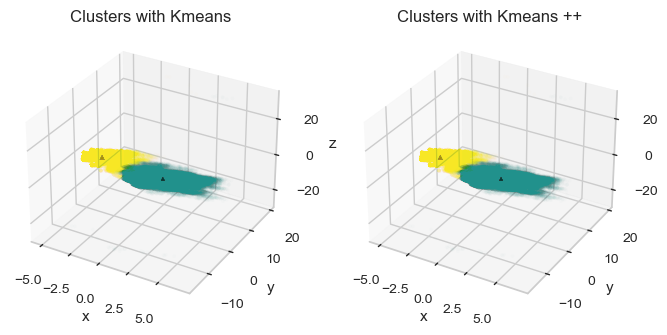

In [28]:
# Scatterplot of the results from Kmeans and Kmeans ++

# Setting plot environment
data = pd.read_json('famc_3.json', lines=True)
datav = data.values

# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, subplot_kw={'projection': '3d'})

# Kmeans Results
# Setting cluster labels for Kmeans
cluster_labels_kmeans = keys3
n_clusters_kmeans = 2
colors_kmeans = cm.viridis(np.array(cluster_labels_kmeans + np.ones(np.shape(np.array(cluster_labels_kmeans))), dtype=np.float64).astype(float) / n_clusters_kmeans)

# Scatterplot of the data
ax1.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, alpha=0.01, c=colors_kmeans, edgecolor="k"
)

# Centroids of the kmeans
centers_kmeans = np.array(centroids_final, dtype=np.float64)
ax1.scatter(
    centers_kmeans[:, 0],
    centers_kmeans[:, 1],
    centers_kmeans[:, 2],
    marker="^",
    c="black",
    alpha=1,
    s=10,
    edgecolor="k",
)
ax1.set_title('Clusters with Kmeans')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

# Kmeans ++ Results
# Setting cluster labels for Kmeans ++
cluster_labels_kmeans_pp = keys_pp3
colors_kmeans_pp = cm.viridis(np.array(cluster_labels_kmeans_pp + np.ones(np.shape(np.array(cluster_labels_kmeans_pp))), dtype=np.float64).astype(float) / n_clusters_kmeans)

# Scatterplot of results from Kmeans ++
ax2.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, alpha=0.01, c=colors_kmeans_pp, edgecolor="k"
)

# Centroids for Kmeans ++
centers_kmeans_pp = np.array(centroids_pp, dtype=np.float64)
ax2.scatter(
    centers_kmeans_pp[:, 0],
    centers_kmeans_pp[:, 1],
    centers_kmeans_pp[:, 2],
    marker="^",
    c="black",
    alpha=1,
    s=10,
    edgecolor="k",
)
ax2.set_title('Clusters with Kmeans ++')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

plt.show()


### 2.3.5: ChatGPT recommended clustering algorithm

First of all, we asked ChatGPT (3.5) to suggest us some clustering algorithms that weren't Kmeans or one of its variants. The answer it gave us was the following: 

"Certainly! One alternative to k-means clustering is the Hierarchical Clustering algorithm. Hierarchical clustering builds a tree of clusters, also known as a dendrogram, by successively merging or splitting clusters. There are two main types of hierarchical clustering:

- Agglomerative Hierarchical Clustering:     
    How it works: It starts with individual data points as separate clusters and merges them iteratively based on some similarity measure until only one cluster remains.
    Pros: It does not require the number of clusters to be specified in advance, and the results can be visualized using a dendrogram.
    Cons: It can be computationally expensive for large datasets.

- Divisive Hierarchical Clustering:      
    How it works: It starts with all data points in a single cluster and then splits them into smaller clusters iteratively until each data point is in its own cluster.
    Pros: Similar to agglomerative clustering, it does not require specifying the number of clusters beforehand.
    Cons: It can also be computationally expensive.

- Another alternative is the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm:     
    How it works: DBSCAN groups together data points that are close to each other and identifies outliers as data points that are far from any cluster.
    Pros: It can discover clusters of arbitrary shapes and is robust to outliers. It does not require specifying the number of clusters.
    Cons: It may have difficulty with datasets of varying density, and the results can be sensitive to the choice of parameters.
    These are just a couple of examples, and there are many other clustering algorithms available, each with its strengths and weaknesses. The choice of algorithm depends on the specific characteristics of your data and the goals of your analysis."


We decided to perform the clustering usinf DBSCAN due to the large computational cost of using agglomerative clustering and the fact that we have a dataset that, even after PCA, has nine features. We were also interested to see if DBSCAN identified the points arranged along the horizontal line at elevation (about) -1.7 as one cluster and the remainder as another, since, as ChatGPT mentioned, DBSCAN should identify clusters of each shape, and the one between these two groups seems to be one of the most pronounced divisions within the dataset (at least in terms of the first two principal components, since from the plot we can only see the behavior of the points along these two directions).

To get the code below, we asked ChatGPT to provide us one, then we adjusted it to our needs by loading our data, and deleting the scaling part, since we the data we have is already been normalized. We also added a scatterplot of the results, to be able to visualize them. Besides, to make sure we had good parameters, we asked ChatGPT to provide us a code to select them based on our data.

In [29]:
parameter_grid = {'eps': [0.5, 1],
                  'min_samples': [100, 500, 1000]}

best_silhouette_score = -1
best_params = None

for eps_value in parameter_grid['eps']:
    for min_samples_value in tqdm(parameter_grid['min_samples']):
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        labels = dbscan.fit_predict(data)
        silhouette = silhouette_score(data, labels)
        
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_params = {'eps': eps_value, 'min_samples': min_samples_value}

print("Best Parameters:", best_params)


100%|██████████| 3/3 [11:39<00:00, 233.03s/it]

Best Parameters: {'eps': 1, 'min_samples': 500}


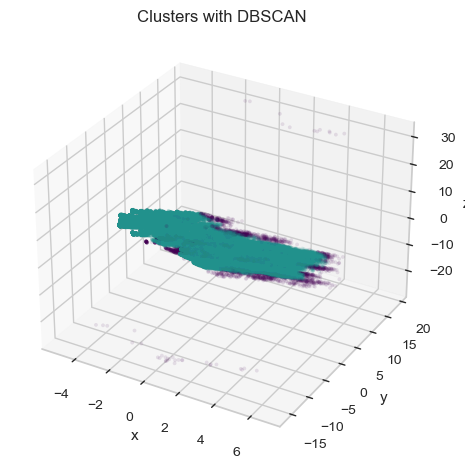

In [30]:
# Load your preprocessed dataset
data = pd.read_json('famc_3.json', lines=True)

# Create and fit the DBSCAN model
# The eps parameter controls the maximum distance between two samples for one to be considered as in the neighborhood of the other
# The min_samples parameter sets the number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan.fit(data)

# Access the labels assigned to each data point
labels = dbscan.labels_

# Adding labels to the original dataset, not the one resulting from PCA
originaldata = pd.read_json('allvariables.json', lines=True)
originaldata.insert(0, 'Cluster', labels)

# Scatterplot of the results
datav = data.values
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n_clusters = len(set(labels))

colors = cm.viridis(np.array(labels + np.ones(np.shape(np.array(labels))), dtype=np.float64).astype(float) / n_clusters)

ax.scatter(
    datav[:, 0], datav[:, 1], datav[:, 2], marker=".", s=30, lw=0, c=colors, alpha=0.1, edgecolor="k"
)

plt.title('Clusters with DBSCAN')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()


In [31]:
datafamc = pd.read_json('famc_3.json', lines=True).values

# Sampling data and saving the Silhouette score (not on the whole dataset for computational reasons)
silscore = []
for sample_extraction in range(30):
    silscore.append(silhouette_score(datafamc, labels, sample_size = 1000, random_state=100))

# Average Silhouette score as representative of the real one
avg_silscore = sum(silscore)/len(silscore)
print('The Silhouette score for the DBSCAN model is:', round(avg_silscore, 2))

The Silhouette score for the DBSCAN model is: 0.43


From the scatterplot, we can see that even in this case we have two different clusters, but they are not the same as the ones obtained from Kmeans. This makes sense since this clusters are based on the density of the points, and they're not spherical (as the ones formed used Kmeans). The Silhouette score for the two models are comparable, so I don't think one methods performs significantly better than the other one.

## 2.4: 2.4 Analysing your results!

In order ot identify the variables that are relevant to the clusters' distincition, we looked at the summary of the features' representation after the dimentionality reduction. Our intuition was that the features which are more represented after this procedure were those that identify clusters. Following this path, we choose to analyze the features '*onefilm*', '*avg_duration*' and '*num_films*'.

Since the second and third feature were divided into four cathegories, using their quantiles. The first one is a binary variable, so we considered only two categories for it, following its natural division given from the value it takes. 

**1st variable: *onefilm***

In [32]:
# Dataset copy to create the pivot table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'onefilm']]

# Summarizing values
pivotpart = dfpivot.groupby('Cluster').agg(list)
takeproportion = lambda l: sum(l)/len(l)
pivotpart['No_films']= pivotpart.onefilm.apply(lambda x: round(takeproportion(x) * 100))
pivotpart['At_least_one_film'] = pivotpart.onefilm.apply(lambda x: round((1 -takeproportion(x)) * 100))

# Dropping unused columns
pivotpart.drop('onefilm', axis=1, inplace=True)

#Showing pivot table
pivotpart

,No_films,At_least_one_film
Cluster,,
0,100,0
1,7,93


Our intuition lead us right with *'onefilm'*: we can see that all the points in one cluster are clients that didn't saw any films, and, on the other hand, the 93% of the clients in the other cluster have seen at least one film. This makes us state that *onefilm* is a relevant variable to distinguish between the clusters.

**3rd variable: *avg_duration***

In [33]:
# Dataset copy to create table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'avg_duration']]

# Partitioning 'avg_duration' values into four categouries using the quartiles
avg_duration_part = dfpivot.avg_duration.quantile([.25, .5, .75]).values
dfpivot['average_duration_first_quartile'] = dfpivot.avg_duration.apply(lambda row: row <= avg_duration_part[0] )
dfpivot['average_duration_second_quartile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[1]) & (row > avg_duration_part[0]))
dfpivot['average_duration_third_quartile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[2]) & (row > avg_duration_part[1]) )
dfpivot['average_duration_fourth_quartile'] = dfpivot.avg_duration.apply(lambda row: row > avg_duration_part[2] )

# Summarizing the results: getting the percentage of each subcategory
pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.average_duration_first_quartile = pivotpart.average_duration_first_quartile.apply(takepercentage)
pivotpart.average_duration_second_quartile = pivotpart.average_duration_second_quartile.apply(takepercentage)
pivotpart.average_duration_third_quartile = pivotpart.average_duration_third_quartile.apply(takepercentage)
pivotpart.average_duration_fourth_quartile = pivotpart.average_duration_fourth_quartile.apply(takepercentage)

# Dropping unused column
pivotpart.drop('avg_duration', axis=1, inplace=True)

# Showing pivot table
pivotpart

,average_duration_first_quartile,average_duration_second_quartile,average_duration_third_quartile,average_duration_fourth_quartile
Cluster,,,,
0,0,26,37,37
1,93,3,2,1


For *avg_duration*, we have that one cluster contains only points for which this variable has values that are over the first quartile, while the other one has the 93% of the points with *avg_duration* below the first quartile, only 7% of the points with values between the second and the third quartile, and no points above the third one. This draws the threshold for this feature to distinguish between the two clusters to the first quartile. For further investigation, we now want to see which is the minimum of this feature, and how the quartiles are distributed.

In [34]:
print('The minimum of avg_duration is:', dftotal3.avg_duration.min())
pd.DataFrame(avg_duration_part, index= [0.25, 0.5, 0.75], columns=['Quantiles of avg_duration'] )

The minimum of avg_duration is: 0.0


,Quantiles of avg_duration
0.25,0.00000
0.50,80.93750
0.75,705.56975


We can see that, since 0 is the minimum of the values taken from *avg_duration*, and it's also the first quartile of its distribution, it's reasonable to think that we have at least the 25% of the data with *avg_duration* = 0, and looking at how big the values of the second and third quartile are compared tothat one, we can say that there's a portion of the data that it's separeted from the other due to this value, which is consistent with what we said before. 

**3rd variable: *num_films***

In [35]:
# Dataset copy to compute pivot table
dfpivot = dftotal3.copy()
dfpivot = dfpivot[['Cluster', 'num_films']]

# Partitioning 'num_films' values into four categouries using the quartiles
num_films_part = dfpivot.num_films.quantile([.25, .5, .75]).values

# Creating new columns that indicate in what interquartile range row['num_film'] is
dfpivot['num_films_first_quartile'] = dfpivot.num_films.apply(lambda row: row <= num_films_part[0] )
dfpivot['num_films_second_quartile'] = dfpivot.num_films.apply(lambda row: (row <= num_films_part[1]) & (row > num_films_part[0]))
dfpivot['num_films_third_quartile'] = dfpivot.num_films.apply(lambda row: (row <= num_films_part[2]) & (row > num_films_part[1]) )
dfpivot['num_films_fourth_quartile'] = dfpivot.num_films.apply(lambda row: row > num_films_part[2] )

# Summarizing the results: getting the percentage of each subcategory
pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.num_films_first_quartile = pivotpart.num_films_first_quartile.apply(takepercentage)
pivotpart.num_films_second_quartile = pivotpart.num_films_second_quartile.apply(takepercentage)
pivotpart.num_films_third_quartile = pivotpart.num_films_third_quartile.apply(takepercentage)
pivotpart.num_films_fourth_quartile = pivotpart.num_films_fourth_quartile.apply(takepercentage)

# Dropping unused column
pivotpart.drop('num_films', axis=1, inplace=True)

# Showing pivot table
pivotpart

,num_films_first_quartile,num_films_second_quartile,num_films_third_quartile,num_films_fourth_quartile
Cluster,,,,
0,20,18,31,30
1,67,20,11,1


As we can see from the pivot, *num_films* seems more relevant to identify one of the two cluster than the other one. Indeed, for the first-mentioned cluster we have that 68% of the clients assigned to it have watched a small (= under the first quartile) number of films, and the percentage of clients assigned to this cluster decreases progressively when looking to the other sections for this feature. 
On the other hand, when looking at the percentage of clients assigned to the other cluster in respect to the number of films watched, we can see that they're splitted 40/60 for the first and second half of possible values, and that there is no differences (in terms of percentages) between the first and second quartile, and there's only one point percentage of difference between the third and the fourth one.

**Clustering performance: Silhouette score**

In [76]:
datafamc = pd.read_json('famc_3.json', lines=True).values

# Sampling data and saving the Silhouette score (not on the whole dataset for computational reasons)
silscore = []
for sample_extraction in range(30):
    silscore.append(silhouette_score(datafamc, keys3, sample_size = 1000, random_state=100))

# Average Silhouette score as representative of the real one
avg_silscore = sum(silscore)/len(silscore)
print('The Silhouette score for our model is:', round(avg_silscore, 2))

The Silhouette score for our model is: 0.44


The Silhouette score we get is similar to the one gotten using the pre-implemented Kmenas method (computed to decide the number of clusters). As a consequence, the conclusions we get from this score are the same of the ones above: the score we get it's too low to say that we have well-separated clusters, since a reasonable Silhouette score is above 0.5. Anyway, the value is close to 0.44 so we think that there are some recurrent patterns in the data, even though they are not so strong.